In [1]:
"""

Variational Autoencoder with a STN and Modified Loss function and inverse STN and compare reconstruction loss
Removed the classification part 
Add the cost function of new VAE implementation of Tensorflow documentation

Binary cross entropy equation - to be implemented

This is a MNIST classifier 

Add a decoder to clip values after inverse STN 

Encoder(Localizaton network) -> CNN to predict affine transformation matrix
STN -> Apply affine transformation
Decoder -> CNN to classify transformed images from STN

"""


'\n\nVariational Autoencoder with a STN and Modified Loss function and inverse STN and compare reconstruction loss\nRemoved the classification part \nAdd the cost function of new VAE implementation of Tensorflow documentation\n\nBinary cross entropy equation - to be implemented\n\nThis is a MNIST classifier \n\nAdd a decoder to clip values after inverse STN \n\nEncoder(Localizaton network) -> CNN to predict affine transformation matrix\nSTN -> Apply affine transformation\nDecoder -> CNN to classify transformed images from STN\n\n'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras import Model
import numpy as np
from utils.data_manager import ClutteredMNIST
from utils.visualizer import plot_mnist_sample
from utils.visualizer import print_evaluation
from utils.visualizer import plot_mnist_grid
from components.STN import BilinearInterpolation

## Dataset creation

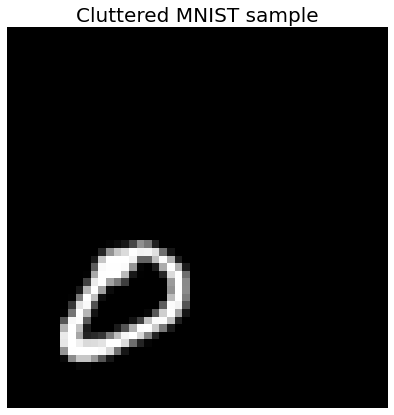

In [3]:
dataset_path = "./datasets/mnist_cluttered_60x60_6distortions.npz"
batch_size = 256
num_epochs = 30

# data_manager = ClutteredMNIST(dataset_path)
# train_data, val_data, test_data = data_manager.load()
# x_train, y_train = train_data
x_train = np.load('./data/pyro-mnist.npy')
x_train = x_train.reshape((-1, 50, 50 ,1))
plot_mnist_sample(x_train[7])

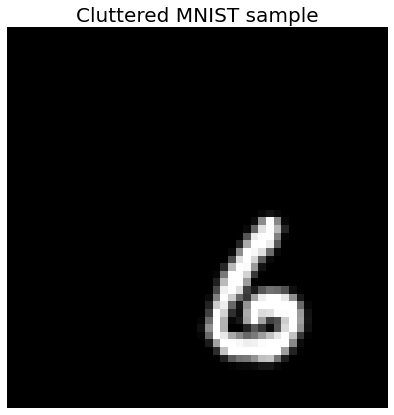

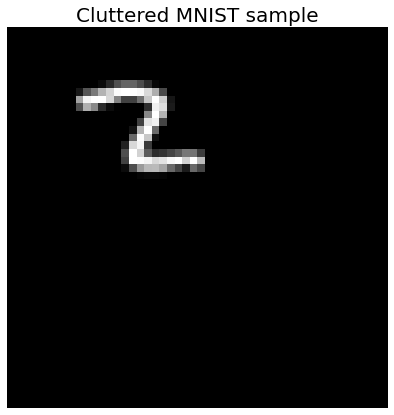

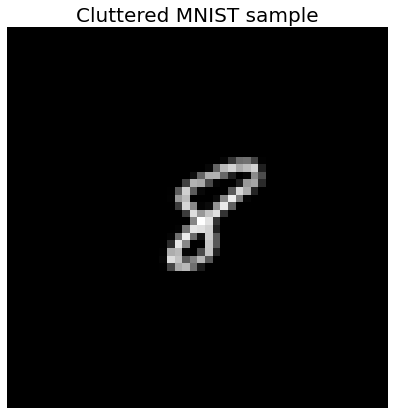

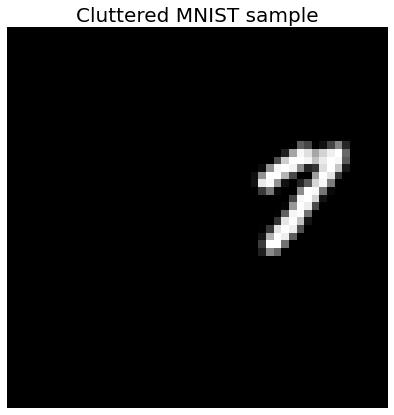

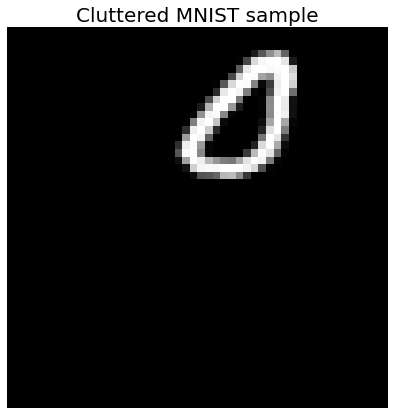

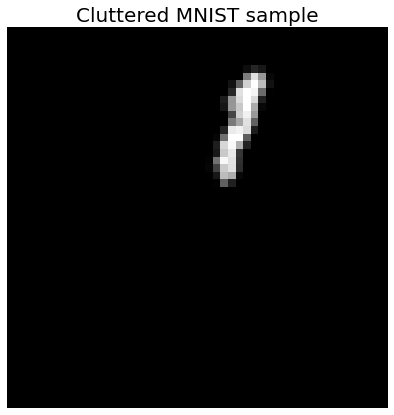

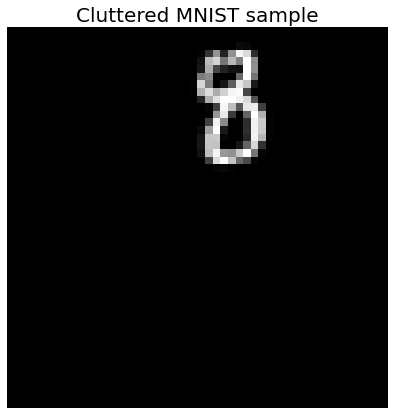

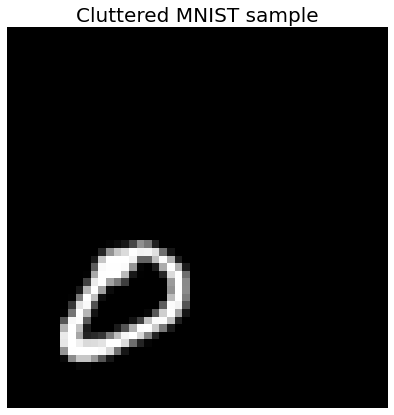

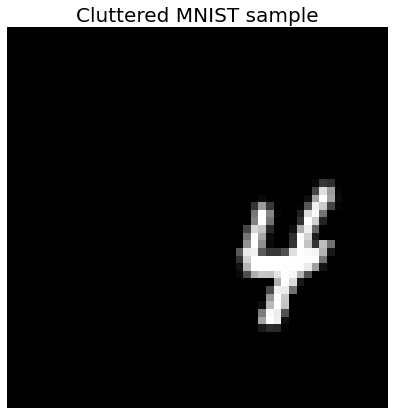

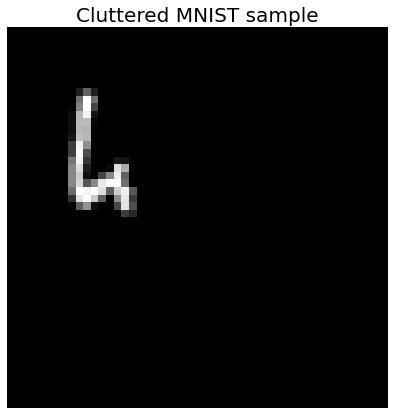

In [4]:
for i in range(10):
    plot_mnist_sample(x_train[i])

## Sampling layer

In [5]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder layer

In [6]:
class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=3,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.conv_1 = layers.Conv2D(20, (5, 5), padding='same', activation='relu')
    self.max_1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv_2 = layers.Conv2D(20, (5, 5), activation='relu')
    self.max_2 = layers.MaxPool2D(pool_size=(2, 2))
    
    self.flatten = layers.Flatten()
    
    self.dense_1 = layers.Dense(50, activation='relu')
    
    self.dense_mean = layers.Dense(3)
    self.dense_log_var = layers.Dense(3)
    
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.max_1(x)
    x = self.conv_2(x)
    x = self.max_2(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


In [7]:
class DigitEncoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               name='digit_encoder',
               **kwargs):
    super(DigitEncoder, self).__init__(name=name, **kwargs)
    self.conv_1 = layers.Conv2D(20, (3, 3), padding='same', activation='relu')
    self.max_1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv_2 = layers.Conv2D(20, (3, 3), activation='relu')
    self.max_2 = layers.MaxPool2D(pool_size=(2, 2))
    
    self.flatten = layers.Flatten()
    
    self.dense_1 = layers.Dense(200, activation='relu')
    
    self.dense_mean = layers.Dense(50)
    self.dense_log_var = layers.Dense(50)
    
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.max_1(x)
    x = self.conv_2(x)
    x = self.max_2(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


## Decoder layer

In [8]:
class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.flatten = layers.Flatten()
    self.dense_1 = layers.Dense(2500, activation='sigmoid')
    self.reshape = layers.Reshape((-1, 50, 50))

    
  def call(self, inputs):
    x = self.flatten(inputs)
    x = self.dense_1(x)
    x = self.reshape(x)
    return x


In [9]:
class DigitDecoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               name='decoder',
               **kwargs):
    super(DigitDecoder, self).__init__(name=name, **kwargs)
    self.dense_1 = layers.Dense(100, activation='relu')
    self.dense_2 = layers.Dense(900, activation='relu')
    self.reshape = layers.Reshape((30, 30, 1))

    
  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.reshape(x)
    return x


## Variational Auto Encoder

In [10]:
a = tf.ones((10,3))

In [11]:
b = tf.ones(a.shape)

In [24]:
class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               num_classes,
               intermediate_dim=64,
               latent_dim=3,
               name='autoencoder',
               **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.num_classes = num_classes
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.stn = BilinearInterpolation((30, 30), name='stn_layer')
    self.digit_encoder = DigitEncoder()
    self.digit_decoder = DigitDecoder()
    self.re_stn = BilinearInterpolation((50, 50), name='stn_layer')
#     self.decoder = Decoder()

  def call(self, inputs):
    z_mean, z_log_var, z_where = self.encoder(inputs)
    n = z_where.shape[0]
    z_where_indexes = tf.repeat([[0,0,1,0,0,2]], n, axis=0)
    z_where_selections = tf.repeat([[1.0, 0.0 , 1.0, 0.0, 1.0, 1.0]], n, axis=0)
    z_where_modified = tf.gather(z_where, z_where_indexes, batch_dims=1)
    z_where_modified = tf.math.multiply(z_where_modified, z_where_selections)
    
    inverse_z_where =  tf.map_fn(lambda x: x/x[0], z_where)
    inverse_z_where_compliments = tf.repeat([[1.0, -1.0 , -1.0]], n, axis=0)    
    inverse_z_where = tf.math.multiply(inverse_z_where, inverse_z_where_compliments)
    
    inverse_z_where_modified = tf.gather(inverse_z_where, z_where_indexes, batch_dims=1)
    inverse_z_where_modified = tf.math.multiply(inverse_z_where_modified, z_where_selections)
    
    
    transformed_image = self.stn([inputs, z_where_modified])
    
    z_what_mean, z_what_log_var, z_what = self.digit_encoder(transformed_image)
    reconstructed_crop = self.digit_decoder(z_what)
    
    reconstructed_image = self.re_stn([reconstructed_crop, inverse_z_where_modified])
    
    # Add KL divergence regularization loss.
    kl_loss_where = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss_where)
    
    kl_loss_what = - 0.5 * tf.reduce_mean(
        z_what_log_var - tf.square(z_what_mean) - tf.exp(z_what_log_var) + 1)
    self.add_loss(kl_loss_what)
    
#     clipped_image = self.decoder(reconstructed_image)

    return transformed_image, [z_mean, z_log_var, z_where], [], reconstructed_image

In [25]:
num_classes = 10
vae = VariationalAutoEncoder(num_classes, 64, 6)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
crossentropy_loss_fn = tf.keras.losses.CategoricalCrossentropy()


## Training

In [27]:
epochs = 100
batch_size = 128
iterations = x_train.shape[0] // batch_size
loss_metric = tf.keras.metrics.Mean()
mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss_log_fn = tf.keras.losses.MeanSquaredLogarithmicError()


In [28]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


In [29]:
for epoch in range(epochs):  
    print('Start of epoch %d' % (epoch,))
    inital_loss = 0
    # Iterate over the batches of the dataset.
    for batch_arg in range(iterations):
        
        with tf.GradientTape() as tape:
            arg_0 = batch_arg * batch_size
            arg_1 = (batch_arg + 1) * batch_size
            x_batch = x_train[arg_0:arg_1]
            
            transformed_image, (z_mean, z_log_var, z_where), clipped_image ,reconstructed_image = vae(x_batch)
            
#             cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=classification, labels=y_batch)
#             logpx_z = -tf.reduce_sum(cross_ent, axis=[1])
#             logpz = log_normal_pdf(z_where, 0., 0.)
#             logqz_x = log_normal_pdf(z_where, z_mean, z_log_var)
#             loss =  -tf.reduce_mean(logpz - logqz_x)
            loss = mse_loss_log_fn(x_batch, reconstructed_image)
#             print('***********')
#             print(loss)
            loss += sum(vae.losses)
            
            inital_loss += sum(vae.losses)
#             print(vae.losses)
#             print(inital_loss)
            
#             loss = crossentropy_loss_fn(y_batch, classification)
#             loss += sum(vae.losses)
        
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        
        loss_metric(loss)

        if batch_arg % 10 == 0:
          print('step %s: mean loss = %s' % (batch_arg, loss_metric.result()))
    print('Epoch loss:{}'.format(inital_loss))
        

Start of epoch 0
step 0: mean loss = tf.Tensor(0.015387576, shape=(), dtype=float32)
step 10: mean loss = tf.Tensor(0.0117752105, shape=(), dtype=float32)
step 20: mean loss = tf.Tensor(0.010919567, shape=(), dtype=float32)
step 30: mean loss = tf.Tensor(0.010599704, shape=(), dtype=float32)
step 40: mean loss = tf.Tensor(0.010385667, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(0.010262621, shape=(), dtype=float32)
step 60: mean loss = tf.Tensor(0.010198302, shape=(), dtype=float32)
step 70: mean loss = tf.Tensor(0.010155797, shape=(), dtype=float32)
step 80: mean loss = tf.Tensor(0.010091377, shape=(), dtype=float32)
step 90: mean loss = tf.Tensor(0.010041373, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.010019732, shape=(), dtype=float32)
step 110: mean loss = tf.Tensor(0.009994336, shape=(), dtype=float32)
step 120: mean loss = tf.Tensor(0.009981377, shape=(), dtype=float32)
step 130: mean loss = tf.Tensor(0.00996504, shape=(), dtype=float32)
step 140: mean

KeyboardInterrupt: 

In [30]:
vae.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  110896    
_________________________________________________________________
stn_layer (BilinearInterpola multiple                  0         
_________________________________________________________________
digit_encoder (DigitEncoder) multiple                  168120    
_________________________________________________________________
decoder (DigitDecoder)       multiple                  96000     
_________________________________________________________________
stn_layer (BilinearInterpola multiple                  0         
Total params: 375,016
Trainable params: 375,016
Non-trainable params: 0
_________________________________________________________________


In [31]:
visualize = x_train[50:60]

In [32]:
transformed_image, [z_mean, z_log_var, z_where], clipped_image, reconstructed_image = vae(visualize)
# transformed_image, [z_mean, z_log_var, z_where], clipped_image, reconstructed_image

In [33]:
z_mean

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05],
       [ 1.3493552e-04, -3.8817179e-06,  1.0949434e-05]], dtype=float32)>

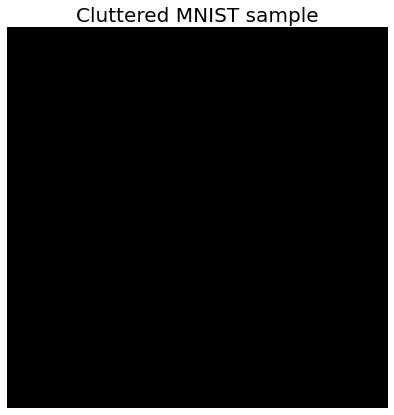

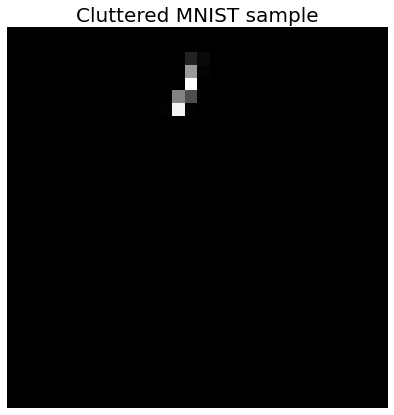

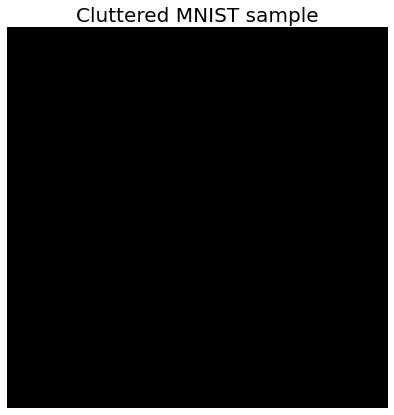

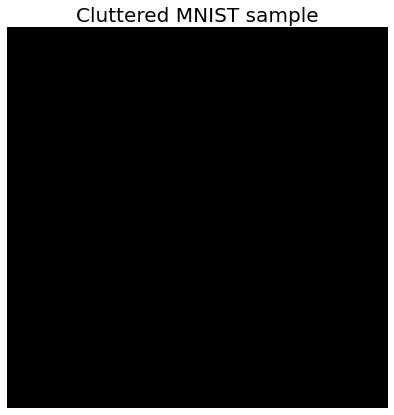

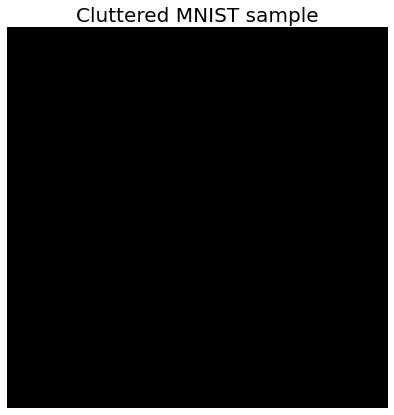

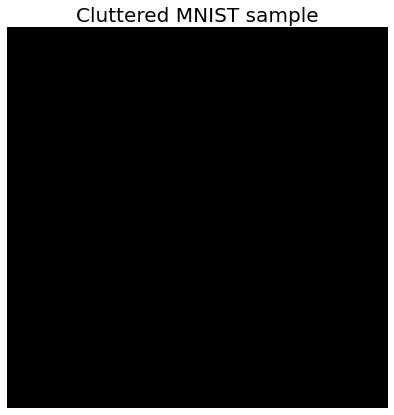

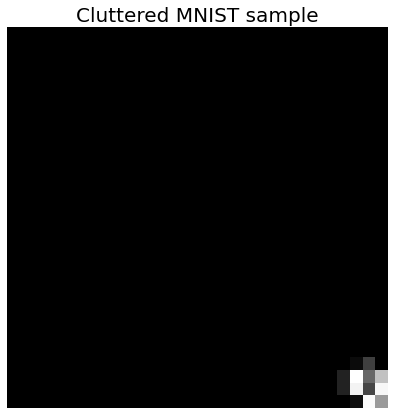

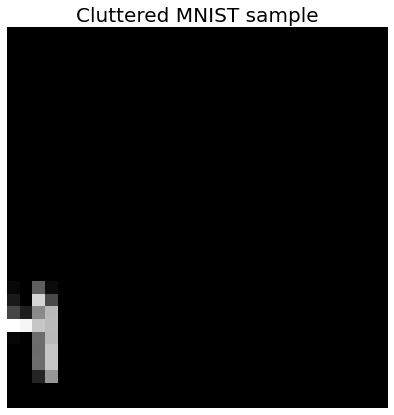

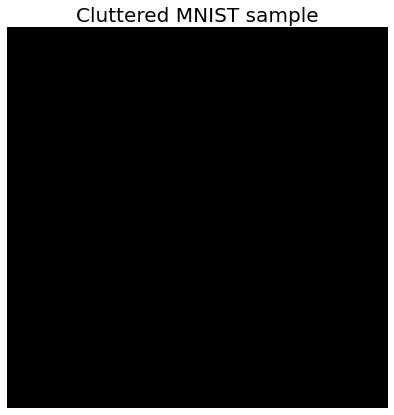

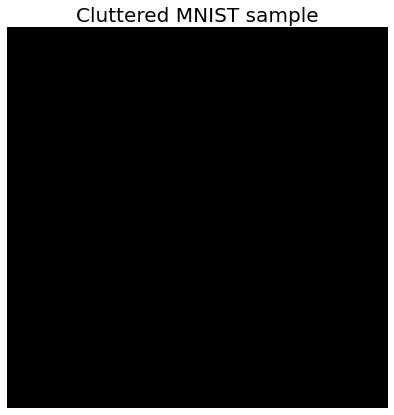

In [34]:
for i in range(10):
    plot_mnist_sample(transformed_image[i])

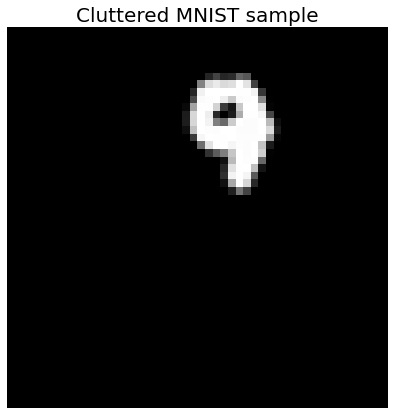

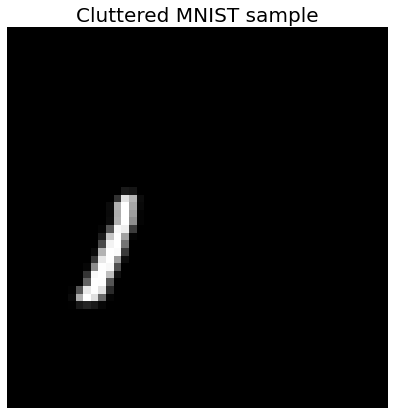

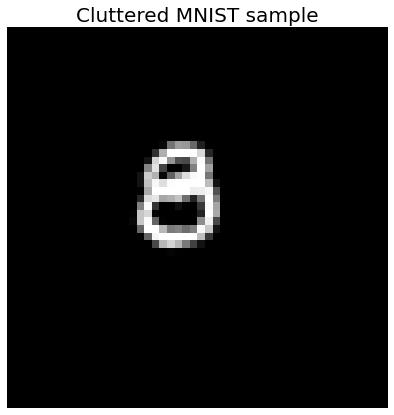

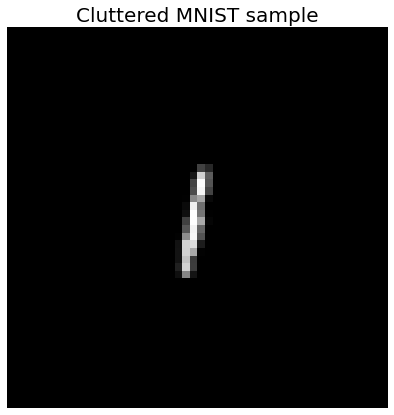

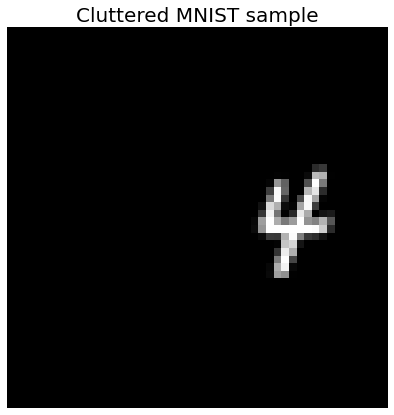

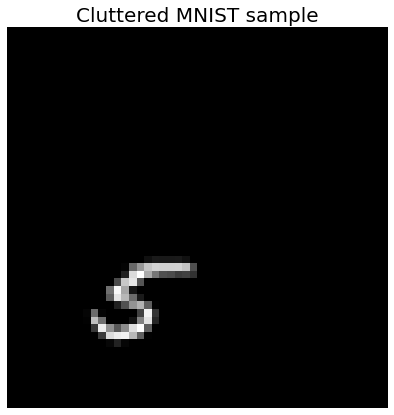

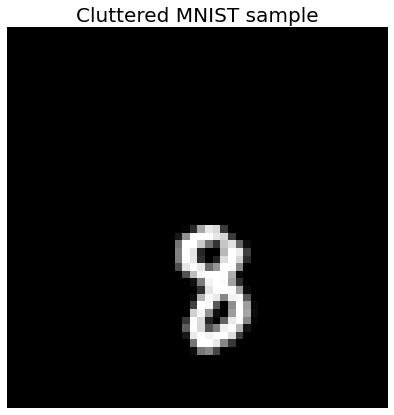

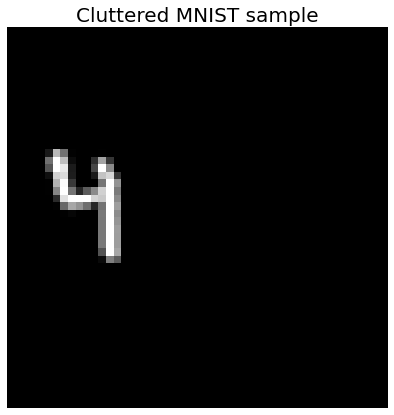

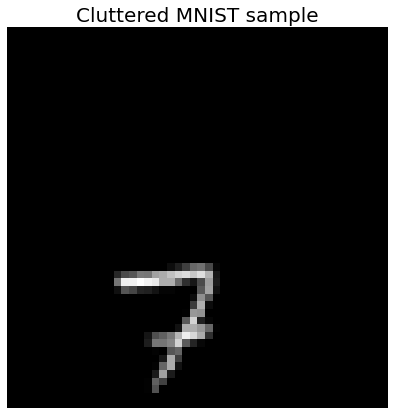

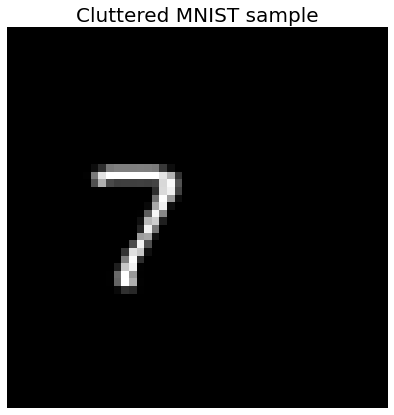

In [23]:
for i in range(10):
    plot_mnist_sample(visualize[i])

In [ ]:
index = 0

In [ ]:
mse_loss_log_fn(visualize, reconstructed_image)

In [ ]:
mse_loss_log_fn(visualize, reconstructed_image)

In [ ]:
plot_mnist_grid(visualize)

In [ ]:
plot_mnist_grid(transformed_image)


In [ ]:
result[3].shape

In [ ]:
plot_mnist_grid(reconstructed_image)
